# Analysis of Latent Space Reaction Attribute Vector for Ketone Reduced to Alcohol
### (For molecules consist Benzene)

_Prepared by: Chih-Wei Hsu, Liang Xu, Christine Chang_

### Ketone $(R=O)$ $\rightarrow$ Alcohol $(R-OH)$

### Goal

Our goal is to evaluate the encoding of chemical reactions in DarkChem's latent space.  To do this, we are exploring the possibility of attribute vector arithmetic, e.g.

$\Big( \overrightarrow{product_{1}} - \overrightarrow{reactant_{1}} \Big) = \overrightarrow{reaction} \stackrel{?}{=} \Big( \overrightarrow{product_{2}} - \overrightarrow{reactant_{2}} \Big)$

### Approach

Our approach differs from prior analysis in the following ways:

   1. A **larger testing set** was used, consisting of more than 100 molecules (versus 10-25 used in prior analyses), which should yield a more robust reaction vector.
   2. A **similar class of reactants** was evaluated for the same reaction type.  For instance, in this analysis only the reactions that reduce the Carbonyl (R=O) to Hydroxyl (R-OH) are chosen.
   
### Key Findings

* The average reactant vector was determined, and the standard deviation was determined and applied to the average vector in order to better understand the latent space. 
    * Predicted products at exactly 1 standard deviation away from the average vector were determined.  For some reactants, this actually returned the expected product of the reaction.  However, for other reactants, this was not the case.
    * An interesting finding is that depending on the type of reactant, the accuracy of the ($\bar{x} \pm \sigma$) had directionality.  For instance, some reactants had a very accurate ($\bar{x} + \sigma$) vector and inaccurate ($\bar{x} - \sigma$) vector, whereas others had the reverse phenomenon.
* The average reactant vector accurately determined all products correctly for a testing set of 10 molecules, within a ~$k = 1-10$ beamsearch.

### Preparation

In [2]:
# Import the pakage we use
import math
import sys
sys.path.append('../')
from fcts import remove_space, r2pcorr, struc2mol
from usefct import difference, vector_magnitude, vector_angle, distribution
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics
from IPython.display import display_html 

Using TensorFlow backend.


In [3]:
# Load model which generate the latent space 
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
# Load training set provided by PNNL
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

In [5]:
# Load several Ketone_Alcohol reactions from designated path as training set
data = pd.read_excel('../../database/classified_reaction_types/ketone_alcohol/ketone_alcohol_6C_train.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
katrain = {'reactants': data['Reactants'], 'products': data['Products']}

..\fcts.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Reactants'][i] = data['Reactants'][i].replace(' ','')
..\fcts.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Products'][i] = data['Products'][i].replace(' ','')


In [6]:
# Show the training reactants we loaded
# Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in katrain['reactants']], molsPerRow=6, subImgSize=(200, 200)) 

In [7]:
# Show the training products we loaded
# Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in katrain['products']], molsPerRow=10, subImgSize=(200, 200))

In [8]:
# Calculate the vectors of reactants and products
rvec = [darkchem.utils.struct2vec(reactant) for reactant in katrain['reactants']]
pvec = [darkchem.utils.struct2vec(product) for product in katrain['products']]
# Transform the data type to np.array 
# For the calculation of latent space vectors
rvec = np.array(rvec).astype(int)
pvec = np.array(pvec).astype(int)

In [9]:
# Generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [10]:
# Transform the data type to DataFrame 
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

### Method

In [11]:
# Calculate the latent path vector for those 17 reactions
path = pvecdf - rvecdf

In [12]:
# Calculate the average of path vector
path_vec =np.array(path.mean().values)

In [13]:
# Show the distribution of magnitude and angle of each path vector
# distribution(path,rvecdf,pvecdf)

In [14]:
# Calculate the average and std deviation of magnitude of path vectors
vector_magnitude(path)

The average magnitude is: 2.5209699069690226
The std magnitude is: 0.7087247831577531


In [15]:
# Calculate the average and std deviation of the angle between products and reactants vectors
vector_angle(rvecdf,pvecdf)

The average angle is: 25.6766847514662
The std angle is: 9.3044568917626


### Prediction

In [16]:
# Load several Ketone_Alcohol reactions from designated path as testing set
data = pd.read_excel('../../database/classified_reaction_types/ketone_alcohol/ketone_alcohol_6C_test.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
katest = {'reactants': data['Reactants'], 'products': data['Products']}

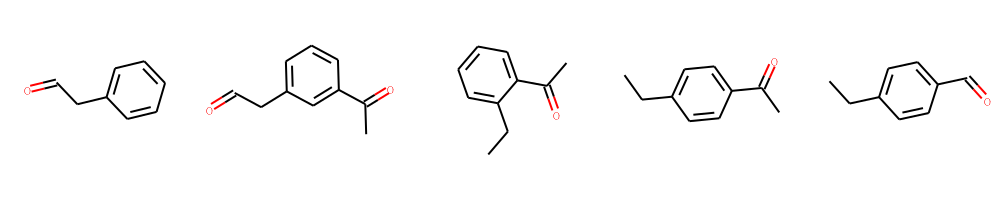

In [17]:
# Show the testing reactants we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in katest['reactants']], molsPerRow=5, subImgSize=(200, 200))

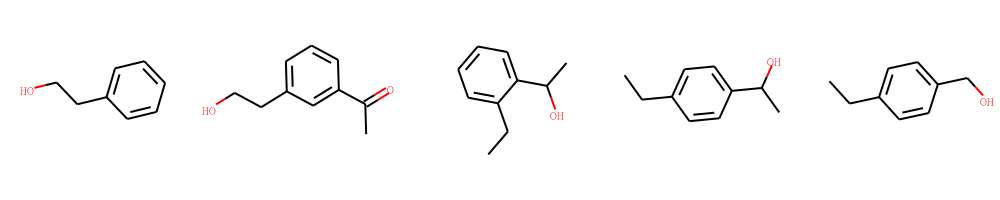

In [18]:
# Show the testing products we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in katest['products']], molsPerRow=5, subImgSize=(200, 200))

The result showed in the dataframe below:

index|             Reactant|             Product|The closest predicted product|Accuracy|
-----|---------------------|--------------------|-----------------------------|--------|
    1|         O=CCc1ccccc1|         OCCc1ccccc1|                 OCCCc1ccccc1|      +C|
    2| O=CCc1cccc(c1)C(=O)C| OCCc1cccc(c1)C(=O)C|         OCCCc1cccc(c1)C(=O)C|      +C|
    3|     CCc1ccccc1C(=O)C|     CCc1ccccc1C(O)C|             OCC(c1ccccc1CC)C|      +C|
    4|   CCc1ccc(cc1)C(=O)C|   CCc1ccc(cc1)C(O)C|           OCC(c1ccc(cc1)CC)C|      +C|
    5|      CCc1ccc(cc1)C=O|      CCc1ccc(cc1)CO|              OCCc1ccc(cc1)CC|      +C|

Below are the prediction of each testing reactions:

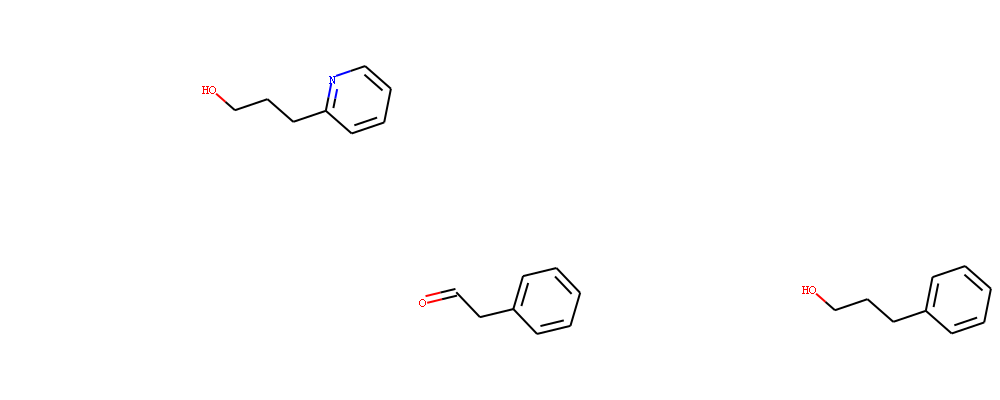

In [19]:
# Predict the 1st reaction in the training set 
r_p1 = katest['reactants'][0]
rvec_p1 = [darkchem.utils.struct2vec(r_p1)]
rvec_p1 = np.array(rvec_p1).astype(int)
r_p1_latent = model.encoder.predict(rvec_p1)
p_p1_latent = r_p1_latent + path_vec
pvec_p1 = model.decoder.predict(p_p1_latent)
p_p1 = darkchem.utils.beamsearch(pvec_p1, k=10)
df = {}
df['p_p1'] = [darkchem.utils.vec2struct(i) for i in p_p1[0]]
df['p_p1_mol'] = [Chem.MolFromSmiles(df['p_p1'][i]) for i in range(len(df['p_p1']))]
img = Chem.Draw.MolsToGridImage(df['p_p1_mol'], molsPerRow=5, subImgSize=(200, 200))
img

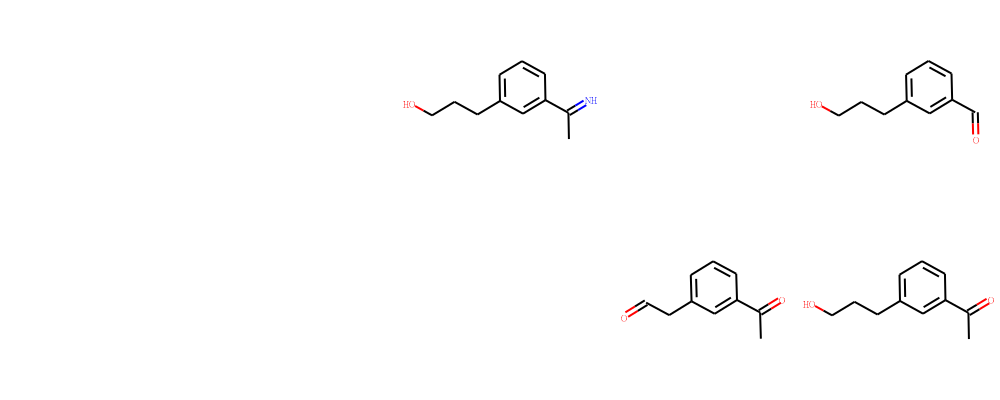

In [20]:
# Predict the 2rd reaction in the training set 
r_p2 = katest['reactants'][1]
rvec_p2 = [darkchem.utils.struct2vec(r_p2)]
rvec_p2 = np.array(rvec_p2).astype(int)
r_p2_latent = model.encoder.predict(rvec_p2)
p_p2_latent = r_p2_latent + path_vec
pvec_p2 = model.decoder.predict(p_p2_latent)
p_p2 = darkchem.utils.beamsearch(pvec_p2, k=10)
df = {}
df['p_p2'] = [darkchem.utils.vec2struct(i) for i in p_p2[0]]
df['p_p2_mol'] = [Chem.MolFromSmiles(df['p_p2'][i]) for i in range(len(df['p_p2']))]
img = Chem.Draw.MolsToGridImage(df['p_p2_mol'], molsPerRow=5, subImgSize=(200, 200))
img

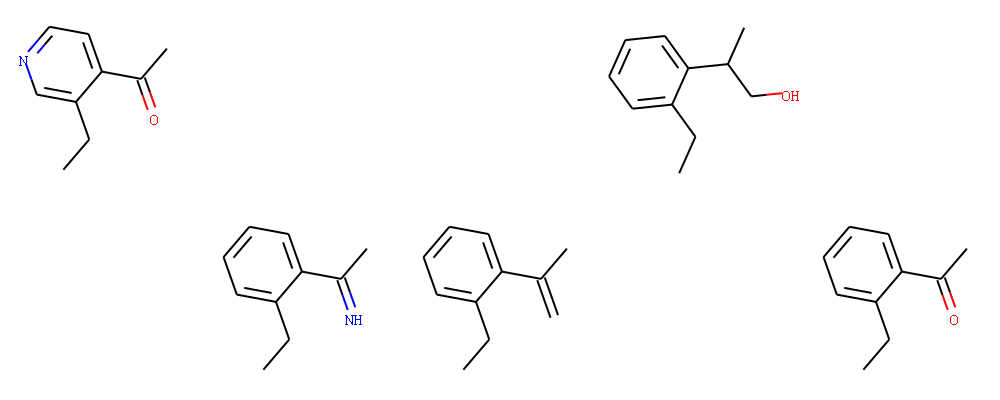

In [21]:
# Predict the 3rd reaction in the training set 
r_p3 = katest['reactants'][2]
rvec_p3 = [darkchem.utils.struct2vec(r_p3)]
rvec_p3 = np.array(rvec_p3).astype(int)
r_p3_latent = model.encoder.predict(rvec_p3)
p_p3_latent = r_p3_latent + path_vec
pvec_p3 = model.decoder.predict(p_p3_latent)
p_p3 = darkchem.utils.beamsearch(pvec_p3, k=10)
df = {}
df['p_p3'] = [darkchem.utils.vec2struct(i) for i in p_p3[0]]
df['p_p3_mol'] = [Chem.MolFromSmiles(df['p_p3'][i]) for i in range(len(df['p_p3']))]
img = Chem.Draw.MolsToGridImage(df['p_p3_mol'], molsPerRow=5, subImgSize=(200, 200))
img

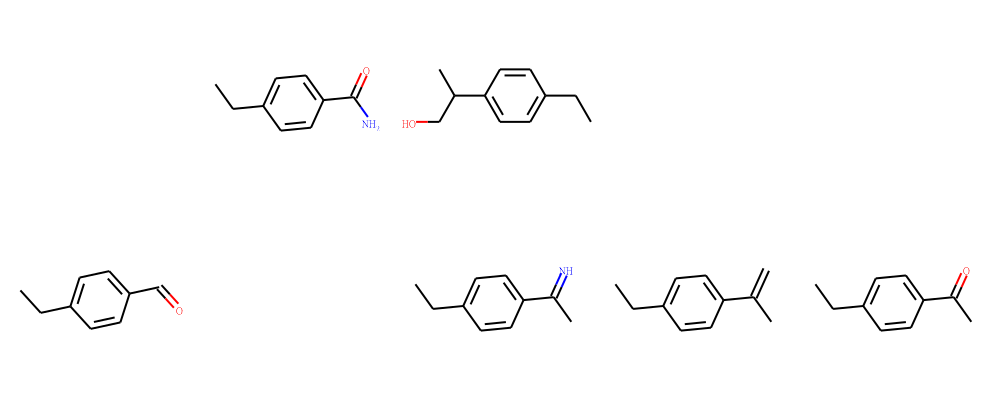

In [22]:
# Predict the 4th reaction in the training set 
r_p4 = katest['reactants'][3]
rvec_p4 = [darkchem.utils.struct2vec(r_p4)]
rvec_p4 = np.array(rvec_p4).astype(int)
r_p4_latent = model.encoder.predict(rvec_p4)
p_p4_latent = r_p4_latent + path_vec
pvec_p4 = model.decoder.predict(p_p4_latent)
p_p4 = darkchem.utils.beamsearch(pvec_p4, k=10)
df = {}
df['p_p4'] = [darkchem.utils.vec2struct(i) for i in p_p4[0]]
df['p_p4_mol'] = [Chem.MolFromSmiles(df['p_p4'][i]) for i in range(len(df['p_p4']))]
img = Chem.Draw.MolsToGridImage(df['p_p4_mol'], molsPerRow=5, subImgSize=(200, 200))
img

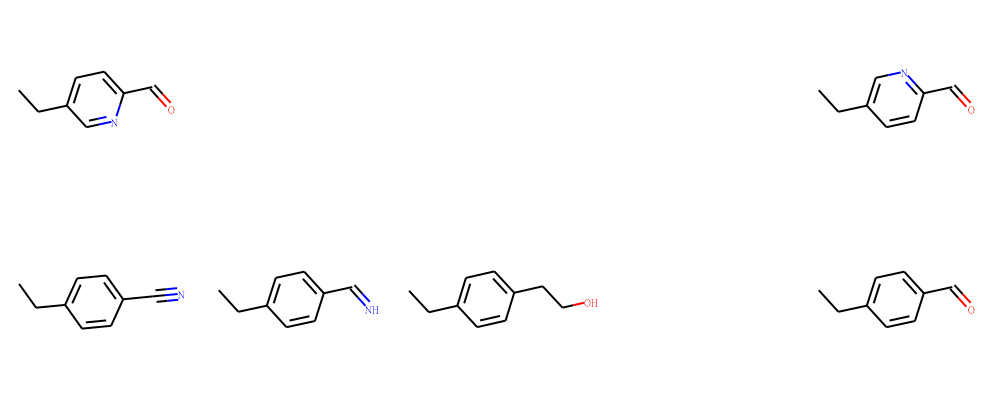

In [23]:
# Predict the 5th reaction in the training set 
r_p5 = katest['reactants'][4]
rvec_p5 = [darkchem.utils.struct2vec(r_p5)]
rvec_p5 = np.array(rvec_p5).astype(int)
r_p5_latent = model.encoder.predict(rvec_p5)
p_p5_latent = r_p5_latent + path_vec
pvec_p5 = model.decoder.predict(p_p5_latent)
p_p5 = darkchem.utils.beamsearch(pvec_p5, k=10)
df = {}
df['p_p5'] = [darkchem.utils.vec2struct(i) for i in p_p5[0]]
df['p_p5_mol'] = [Chem.MolFromSmiles(df['p_p5'][i]) for i in range(len(df['p_p5']))]
img = Chem.Draw.MolsToGridImage(df['p_p5_mol'], molsPerRow=5, subImgSize=(200, 200))
img

Below is the prediction from the generation within 1 std deviation of reaction vector:

In [24]:
# Calculate the vector generated within 1 std dev of the average vector
stdpath_vec = path_vec + 0.7087247831577531
mstdpath_vec = path_vec - 0.7087247831577531

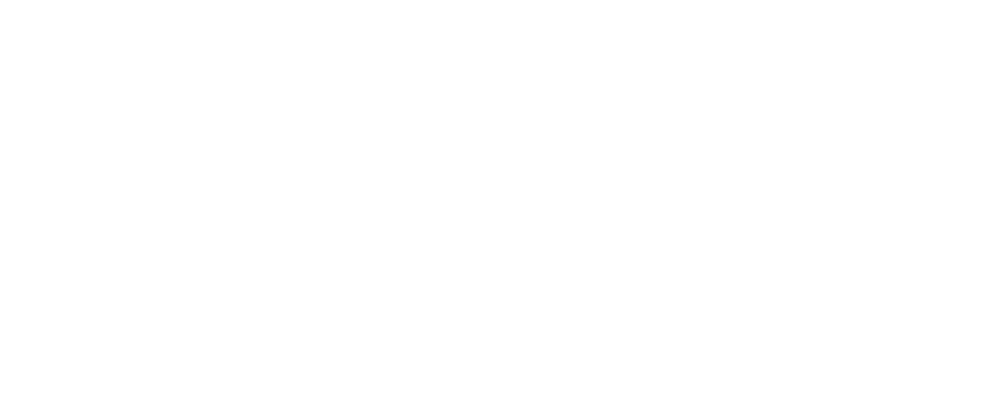

In [25]:
# Predict the 1st reaction in the training set 
r_p1 = katest['reactants'][0]
rvec_p1 = [darkchem.utils.struct2vec(r_p1)]
rvec_p1 = np.array(rvec_p1).astype(int)
rvec_p1 = rvec_p1.reshape(-1,100)
r_p1_latent = model.encoder.predict(rvec_p1)
p_p1_latent = r_p1_latent + stdpath_vec
pvec_p1 = model.decoder.predict(p_p1_latent)
p_p1 = darkchem.utils.beamsearch(pvec_p1, k=10)
p_p1 = p_p1.flatten()
p_p1 = p_p1.reshape(-1,100)
p_p1 = [darkchem.utils.vec2struct(p_p1[i]) for i in range(len(p_p1))]
p_p1 = {'smiles': p_p1}
p_p1 = pd.DataFrame(data = p_p1)
df = struc2mol(p_p1)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))

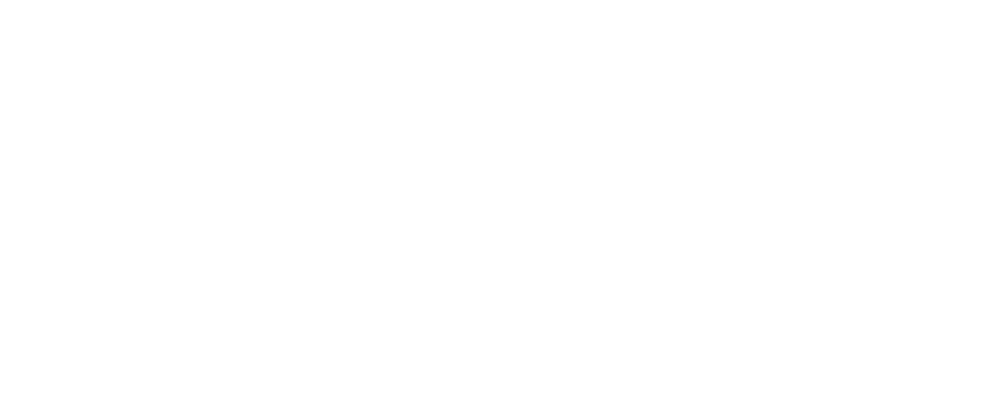

In [26]:
# Predict the 1st reaction in the training set 
r_p1 = katest['reactants'][0]
rvec_p1 = [darkchem.utils.struct2vec(r_p1)]
rvec_p1 = np.array(rvec_p1).astype(int)
rvec_p1 = rvec_p1.reshape(-1,100)
r_p1_latent = model.encoder.predict(rvec_p1)
p_p1_latent = r_p1_latent + mstdpath_vec
pvec_p1 = model.decoder.predict(p_p1_latent)
p_p1 = darkchem.utils.beamsearch(pvec_p1, k=10)
p_p1 = p_p1.flatten()
p_p1 = p_p1.reshape(-1,100)
p_p1 = [darkchem.utils.vec2struct(p_p1[i]) for i in range(len(p_p1))]
p_p1 = {'smiles': p_p1}
p_p1 = pd.DataFrame(data = p_p1)
df = struc2mol(p_p1)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))

In [27]:
# Put the closet predictied product into dictionary
kapred = {'prediction': data['The closest predicted product']}

In [32]:
# Calculate the vectors of reactants and products
cpvec = [darkchem.utils.struct2vec(prediction) for prediction in kapred['prediction']]

# Transform the data type to np.array 
# For the calculation of latent space vectors
cpvec = np.array(cpvec).astype(int)

# Generate the latent space representation for reactants and products
cp_latent = model.encoder.predict(cpvec)

# Transform the data type to DataFrame 
cpvecdf = pd.DataFrame(cp_latent)

# Calculate the latent path vector for those 17 reactions
path = cpvecdf - pvecdf

a = []
for i in range(len(path)):
    s = 0
    for j in range(path.shape[1]):
        s += (path.iloc[i][j])**2
    s = np.sqrt(s)
    a.append(s)
a

[2.1695873603179527,
 4.408980015843711,
 2.3283324993811654,
 3.1163794276000423,
 2.9411816445368695,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]